# Simulate elliptical calibration data - BVM

- simulate a set of Bragg peak positions
- compute a Bragg vector map
- fit the elliptical distortions
- compute a polar elliptical transform
- correct the elliptical distortions

This notebook was written and last tested with py4DSTEM v0.12.7 on 2021.09.30

In [1]:
import numpy as np
import py4DSTEM

## Simulated BVM

Simulate a set of Bragg peak positions drawn from a random distribution about an ellipse

In [2]:
# set parameters

# datacube dims
QNx,QNy = 1024,1024
RNx,RNy = 20,20

# ellipse parameters
x0,y0 = 0,0
a,b = 400,300
theta = np.radians(40)
sigma = 10

# number of peaks per diffraction pattern
N = 100

In [3]:
# generate the Bragg peaks
coordinates = [('qx',float),('qy',float),('intensity',float)]
braggpeaks = py4DSTEM.io.PointListArray(coordinates,(RNx,RNy))
for rx in range(RNx):
    for ry in range(RNy):
        p_s = np.random.uniform(0,2*np.pi,N)
        a_s = np.random.normal(a,sigma,N)
        b_s = np.random.normal(b,sigma,N)
        
        xs = x0 + a_s*np.cos(theta)*np.cos(p_s) - b_s*np.sin(theta)*np.sin(p_s)
        ys = y0 + a_s*np.sin(theta)*np.cos(p_s) + b_s*np.cos(theta)*np.sin(p_s)
        
        data = np.zeros(N,dtype=coordinates)
        data['qx'],data['qy'],data['intensity'] = xs,ys,np.ones(N)
        
        pl = braggpeaks.get_pointlist(rx,ry)
        pl.add_dataarray(data)

Computing Bragg vector map: 100%|██████████| 400/400 [00:03<00:00, 130DP/s] 


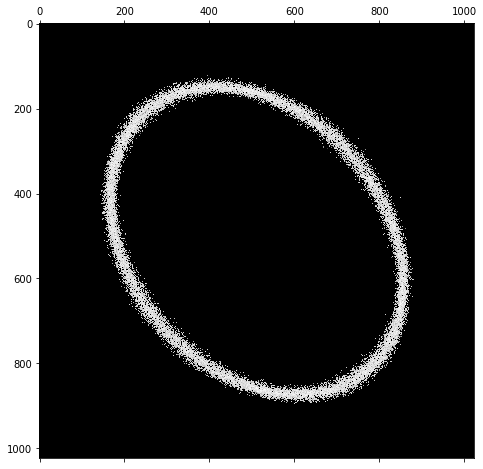

In [4]:
# compute and show the bvm
bvm = py4DSTEM.process.diskdetection.get_bvm(braggpeaks,QNx,QNy)
py4DSTEM.visualize.show(bvm,scaling='log')

## Fit and transform

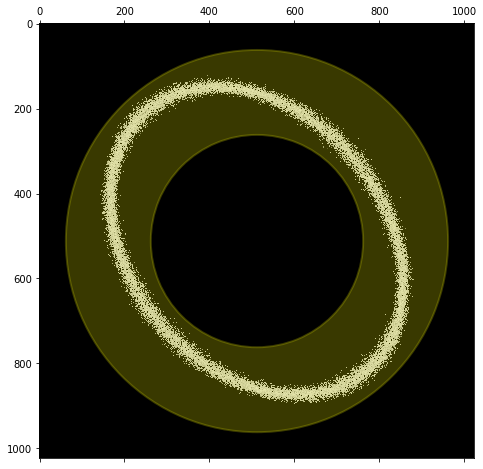

In [5]:
# Select fitting region
center = 512,512
fitradii = 250,450
py4DSTEM.visualize.show(
                bvm,
                annulus={'center':center,'Ri':fitradii[0],'Ro':fitradii[1],'fill':True,'color':'y','alpha':0.3},
                scaling='log')

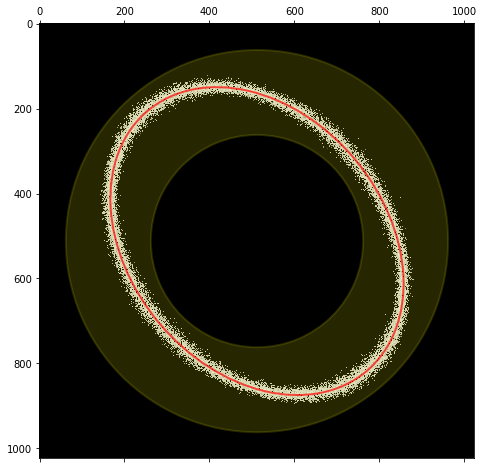

In [6]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
                            bvm,center,fitradii)
py4DSTEM.visualize.show_elliptical_fit(
                            bvm,
                            fitradii,
                            p_ellipse=p_ellipse,
                            fill=True,
                            scaling='log')

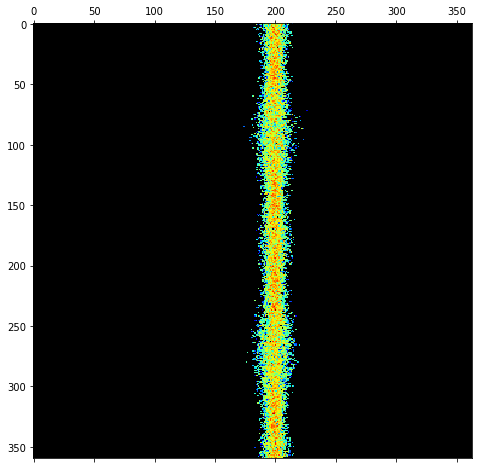

In [7]:
# compute and show a polar elliptical transform
bvm_pe,rr_bvm,pp_bvm = py4DSTEM.process.utils.cartesian_to_polarelliptical_transform(
                                bvm,
                                p_ellipse,
                                dr=2,
                                dphi=np.radians(1))
py4DSTEM.visualize.show(bvm_pe,scaling='power',power=0.25,cmap='jet')

In [8]:
# compare to sim params

# unpack params
x0_fit,y0_fit,a_fit,b_fit,theta_fit = p_ellipse

# handle theta degeneracy
theta = np.mod(theta,np.pi)
theta_fit = np.mod(theta_fit,np.pi)

print("x0, x0_fit = {:.2f}, {:.2f}".format(center[0],x0_fit))
print("y0, y0_fit = {:.2f}, {:.2f}".format(center[1],y0_fit))
print("a, a_fit = {:.2f}, {:.2f}".format(a,a_fit))
print("b, b_fit = {:.5f}, {:.5f}".format(b,b_fit))
print("theta, theta_fit = {:.5f}, {:.5f}".format(theta,theta_fit))
print("")
print("x0 err = {:.3f}%".format(100*(center[0]-x0_fit)/center[0]))
print("y0 err = {:.3f}%".format(100*(center[1]-y0_fit)/center[1]))
print("a err = {:.3f}%".format(100*(a-a_fit)/a))
print("b err = {:.5f}%".format(100*(b-b_fit)/b))
print("theta err = {:.5f}%".format(100*(theta-theta_fit)/theta))

x0, x0_fit = 512.00, 512.07
y0, y0_fit = 512.00, 512.01
a, a_fit = 400.00, 400.39
b, b_fit = 300.00000, 300.49260
theta, theta_fit = 0.69813, 0.69756

x0 err = -0.013%
y0 err = -0.001%
a err = -0.097%
b err = -0.16420%
theta err = 0.08189%


## Correct the braggpeak elliptical distortions

In [9]:
# Correct the peak positions
braggpeaks_corr = py4DSTEM.process.calibration.correct_braggpeak_elliptical_distortions(braggpeaks,p_ellipse)

Computing Bragg vector map: 100%|██████████| 400/400 [00:03<00:00, 130DP/s] 


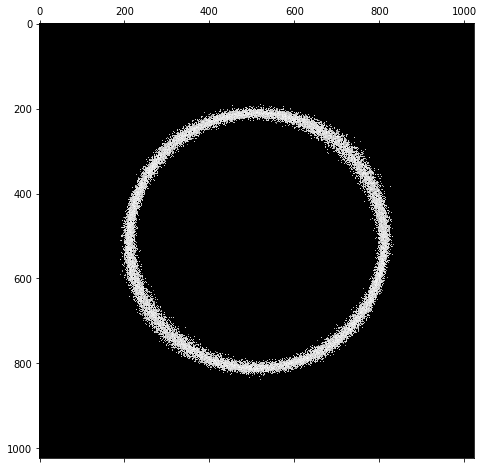

In [10]:
# compute and show the new bvm
bvm_corr = py4DSTEM.process.diskdetection.get_bvm(braggpeaks_corr,QNx,QNy)
py4DSTEM.visualize.show(bvm_corr,scaling='log')

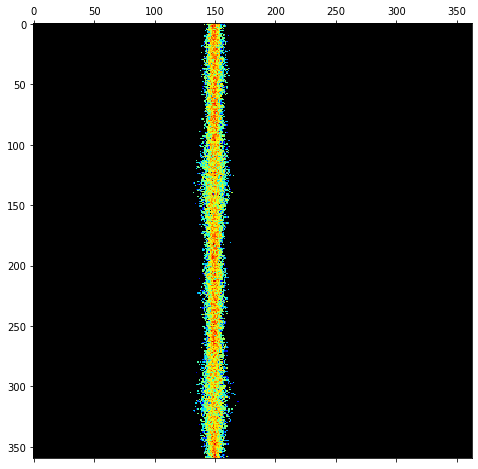

In [11]:
# compute and show a polar transform
bvm_polar,rr_bvm_corr,pp_bvm_corr = py4DSTEM.process.utils.cartesian_to_polarelliptical_transform(
                                bvm_corr,
                                (512,512,1,1,0),
                                dr=2,
                                dphi=np.radians(1))
py4DSTEM.visualize.show(bvm_polar,scaling='power',power=0.25,cmap='jet')